## Creating massive S&P 500 company correlation table for Relationships

https://pythonprogramming.net/stock-price-correlation-table-python-programming-for-finance/

Hello and welcome to part 8 of the Python for Finance tutorial series. In the previous tutorial, we showed how to combine all of the daily pricing data for the S&P 500 companies. In this tutorial, we're going to see if we can find any interesting correlation data. To do this, we'd like to visualize it, since it's a lot of data. We're going to use [Matplotlib](https://pythonprogramming.net/matplotlib-intro-tutorial/) for this, along with Numpy.

Full code up to this point:

In [1]:
import bs4 as bs
import datetime as dt
import os
import pandas as pd
import yfinance as yf
import pickle
import requests
from tqdm import tqdm
from IPython.display import display


def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.strip())
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers


def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.now()
    for ticker in tickers:
        # e.g. BRK.B => BRK-B, BF.B => BF-B
        ticker = ticker.replace('.', '-')
        # just in case your connection breaks, we'd like to save our progress!
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = yf.download(ticker, start=start, end=end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))


def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for ticker in tqdm(tickers):
        # e.g. BRK.B => BRK-B, BF.B => BF-B
        ticker = ticker.replace('.', '-')
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)

        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')

    display(main_df)
    main_df.to_csv('sp500_joined_closes.csv')


# compile_data()

Now we're going to add the following imports and set a style:

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')

Next, we'll begin to build the visualization function:

In [3]:
# def visualize_data():
#     df = pd.read_csv('sp500_joined_closes.csv')

At this point, we could graph any company:

In [4]:
#     df['AAPL'].plot()
#     plt.show()

...But we didn't go through all that work to just graph single companies! Instead, let's look into the correlation of all of these companies. Building a correlation table in Pandas is actually unbelievably simple:

In [5]:
#     df_corr = df.corr()
#     print(df_corr.head())

That's seriously it. The `.corr()` automatically will look at the entire `DataFrame`, and determine the correlation of every column to every column. I've seen paid websites do exactly this as a service. So, if you need some side capital, there you have it!

We can of course save this if we want:

In [6]:
#     df_corr.to_csv('sp500corr.csv')

Instead, we're going to graph it. To do this, we're going to make a heatmap. There isn't a super simple heat map built into `Matplotlib`, but we have the tools to make on anyway. To do this, first we need the actual data itself to graph:

In [7]:
#     data1 = df_corr.values

This will give us a numpy array of just the values, which are the correlation numbers. Next, we'll build our figure and axis:

In [8]:
#     fig1 = plt.figure()
#     ax1 = fig1.add_subplot(111)

Now, we create the heatmap using `pcolor`:

In [9]:
#     heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)

This heatmap is made using a range of colors, which can be a range of anything to anything, and the color scale is generated from the cmap that we use. You can find all of the options for [color maps here](http://matplotlib.org/users/colormaps.html). We're going to use RdYlGn, which is a colormap that goes from red on the low side, yellow for the middle, and green for the higher part of the scale, which will give us red for negative correlations, green for positive correlations, and yellow for no-correlations. We'll add a side-bar that is a colorbar as a sort of "scale" for us:

In [10]:
#     fig1.colorbar(heatmap1)

Next, we're going to set our x and y axis ticks so we know which companies are which, since right now we've only just plotted the data:

In [11]:
#     ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
#     ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)

What this does is simply create tick markers for us. We don't yet have any labels.

Now we add:

In [12]:
#     ax1.invert_yaxis()
#     ax1.xaxis.tick_top()

This will flip our `yaxis`, so that the graph is a little easier to read, since there will be some space between the x's and y's. Generally `matplotlib` leaves room on the extreme ends of your graph since this tends to make graphs easier to read, but, in our case, it doesn't. Then we also flip the xaxis to be at the top of the graph, rather than the traditional bottom, again to just make this more like a correlation table should be. Now we're actually going to add the company names to the currently-nameless ticks:

In [13]:
#     column_labels = df_corr.columns
#     row_labels = df_corr.index
#     ax1.set_xticklabels(column_labels)
#     ax1.set_yticklabels(row_labels)

In this case, we could have used the exact same list from both sides, since `column_labels` and `row_lables` should be identical lists. This wont always be true for all heatmaps, however, so I decided to show this as the proper method for just about any heatmap from a dataframe. Finally:

In [14]:
#     plt.xticks(rotation=90)
#     heatmap1.set_clim(-1,1)
#     plt.tight_layout()
#     #plt.savefig("correlations.png", dpi = (300))
#     plt.show()

We rotate the xticks, which are the actual tickers themselves, since normally they'll be written out horizontally. We've got over 500 labels here, so we're going to rotate them 90 degrees so they're vertical. It's still a graph that's going to be far too large to really see everything zoomed out, but that's fine. The line that says `heatmap1.set_clim(-1,1)` just tells the colormap that our range is going to be from -1 to positive 1. It should already be the case, but we want to be certain. Without this line, it should still be the min and max of your dataset, so it would have been pretty close anyway.

So we're done! The function up to this point:

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
MMM,1.000000,0.804581,0.598505,0.201033,0.579437,0.414873,0.603031,0.571838,0.419620,0.541754,...,0.635525,0.351397,0.368420,0.660294,0.584305,0.619272,0.582134,0.835518,0.768832,0.309512
AOS,0.804581,1.000000,0.876760,0.844697,0.906516,0.801689,0.863959,0.899311,0.741751,0.889636,...,0.904997,0.799503,0.147991,0.896292,0.913000,0.915664,0.811678,0.887020,0.864059,0.847364
ABT,0.598505,0.876760,1.000000,0.878998,0.980031,0.848419,0.968431,0.956231,0.922401,0.893808,...,0.975540,0.865992,-0.018291,0.964827,0.951908,0.961586,0.947003,0.831008,0.823530,0.987220
ABBV,0.201033,0.844697,0.878998,1.000000,0.920610,0.939754,0.804344,0.949567,0.842269,0.936165,...,0.893914,0.923126,-0.303740,0.871484,0.861484,0.914915,0.746939,0.612550,0.702127,0.883093
ACN,0.579437,0.906516,0.980031,0.920610,1.000000,0.887820,0.961527,0.974757,0.905693,0.928994,...,0.966510,0.902660,-0.040508,0.949191,0.957270,0.968419,0.931445,0.803223,0.836184,0.984134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.619272,0.915664,0.961586,0.914915,0.968419,0.871836,0.922502,0.979657,0.886887,0.960028,...,0.974126,0.904500,0.058069,0.960775,0.963360,1.000000,0.874313,0.839925,0.826906,0.952234
ZBRA,0.582134,0.811678,0.947003,0.746939,0.931445,0.749324,0.949731,0.862572,0.900336,0.779879,...,0.901846,0.753967,-0.017340,0.868095,0.911662,0.874313,1.000000,0.771381,0.822594,0.930913
ZBH,0.835518,0.887020,0.831008,0.612550,0.803223,0.676980,0.807364,0.800595,0.718395,0.767915,...,0.864394,0.675891,0.256204,0.864118,0.830302,0.839925,0.771381,1.000000,0.755803,0.759594
ZION,0.768832,0.864059,0.823530,0.702127,0.836184,0.740842,0.791174,0.828701,0.757670,0.803823,...,0.827936,0.649921,0.176243,0.813033,0.825212,0.826906,0.822594,0.755803,1.000000,0.735450


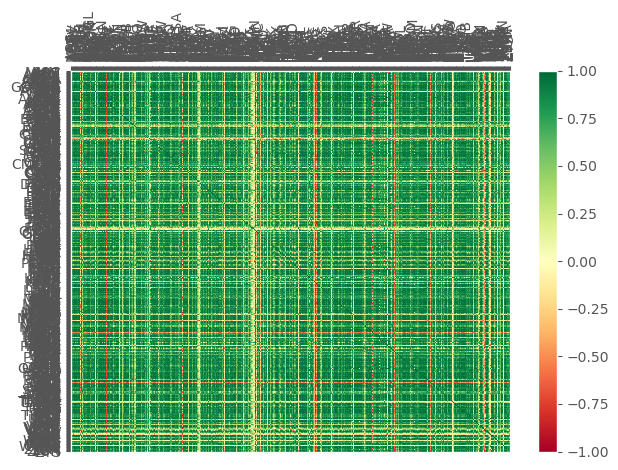

CPU times: user 5.1 s, sys: 75.1 ms, total: 5.17 s
Wall time: 3.8 s


In [15]:
%%time
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    #df['AAPL'].plot()
    #plt.show()
    df_corr = df.corr(numeric_only=True)
    display(df_corr)
    df_corr.to_csv('sp500corr.csv')

    data1 = df_corr.values
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)

    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    fig1.colorbar(heatmap1)

    ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1,1)
    plt.tight_layout()
    #plt.savefig("correlations.png", dpi = (300))
    plt.show()

visualize_data()

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
MMM,1.000000,0.804581,0.598505,0.201033,0.579437,0.414873,0.603031,0.571838,0.419620,0.541754,...,0.635525,0.351397,0.368420,0.660294,0.584305,0.619272,0.582134,0.835518,0.768832,0.309512
AOS,0.804581,1.000000,0.876760,0.844697,0.906516,0.801689,0.863959,0.899311,0.741751,0.889636,...,0.904997,0.799503,0.147991,0.896292,0.913000,0.915664,0.811678,0.887020,0.864059,0.847364
ABT,0.598505,0.876760,1.000000,0.878998,0.980031,0.848419,0.968431,0.956231,0.922401,0.893808,...,0.975540,0.865992,-0.018291,0.964827,0.951908,0.961586,0.947003,0.831008,0.823530,0.987220
ABBV,0.201033,0.844697,0.878998,1.000000,0.920610,0.939754,0.804344,0.949567,0.842269,0.936165,...,0.893914,0.923126,-0.303740,0.871484,0.861484,0.914915,0.746939,0.612550,0.702127,0.883093
ACN,0.579437,0.906516,0.980031,0.920610,1.000000,0.887820,0.961527,0.974757,0.905693,0.928994,...,0.966510,0.902660,-0.040508,0.949191,0.957270,0.968419,0.931445,0.803223,0.836184,0.984134


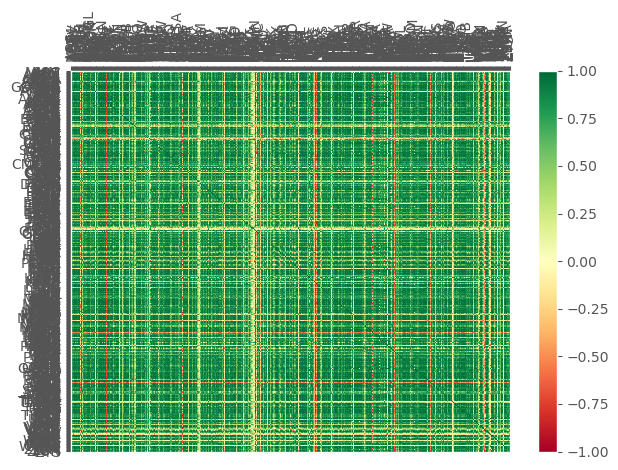

In [16]:
import bs4 as bs
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import os
import pandas as pd
import yfinance as yf
import pickle
import requests
from tqdm import tqdm
from IPython.display import display


def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.strip())
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers


def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.now()
    for ticker in tickers:
        # e.g. BRK.B => BRK-B, BF.B => BF-B
        ticker = ticker.replace('.', '-')
        # just in case your connection breaks, we'd like to save our progress!
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = yf.download(ticker, start=start, end=end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))


def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for ticker in tqdm(tickers):
        # e.g. BRK.B => BRK-B, BF.B => BF-B
        ticker = ticker.replace('.', '-')
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)

        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')

    display(main_df)
    main_df.to_csv('sp500_joined_closes.csv')


def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    df_corr = df.corr(numeric_only=True)
    display(df_corr.head())
    df_corr.to_csv('sp500corr.csv')
    data1 = df_corr.values
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)

    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    fig1.colorbar(heatmap1)

    ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()

    
visualize_data()

Okay, so looking at the correlations, we can see that there are many relationships. The majority of companies are, unsurprisingly, positively correlated. There are quite a few companies that are very strongly correlated with eachother, and there are still quite a few that are very negatively correlated. There are even some companies that are negatively correlated with most companies. We can also see there are many companies with no correlation at all. Chances are, investing in a bunch of companies with zero correlation over time would be a decent way to be diverse, but we really don't know at this point.

Regardless, this data clearly has a lot of relationships already. One must wonder if a machine could recognize and trade based purely on these relationships. Could we be millionairs that easily?! We can at least try!